In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
def compare_sets(ours, theirs):
    our_set = set(ours)
    orig_set = set(theirs)
    int_set = our_set.intersection(orig_set)
    print('{} and {} intersect {}'.format(len(our_set),len(orig_set), len(int_set)))

In [9]:
from io_utils import save_data_to_file
res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
RDIR = os.path.join(res_dir, "entero_data", "results_our_lm")

# Step 1: Select LM genes from SGE Data

In [3]:
# prepare the data so that the zones correspond to different genes
dat_dir = "/share/PI/sabatti/sc_data/intestine2k"
fn = os.path.join(dat_dir, "table_A_LCM_TPM_values.tsv")
lcm_rna_df = pd.read_table(fn, delimiter="\t")
lcm_rna_df.index = lcm_rna_df['external_gene_name']
cols = lcm_rna_df.columns
use_cols = cols[cols.str.startswith('Villus')]
sge_mtx = np.log(1+lcm_rna_df[use_cols])
print(sge_mtx.shape)
sge_mtx.head()
# quality control
mean_thres = 4.5
gene_mean = np.mean(sge_mtx, axis=1)
init_genes = gene_mean[gene_mean > mean_thres]
init_genes = set(init_genes.index)
print(len(init_genes))

(20882, 15)
1005


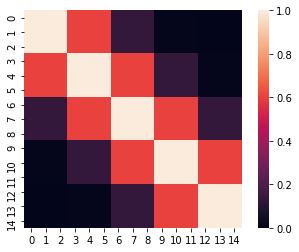

In [4]:
from graph_utils import construct_kernal_graph, construct_knn_naive
data_mtx = sge_mtx.loc[init_genes]
zone_ids = use_cols.to_series().apply(lambda x: x.split('_')[1])
zone_ids = np.expand_dims(zone_ids.values.astype(int), 1)
graph = construct_kernal_graph(zone_ids)
sns.heatmap(graph.toarray(),square=True)
plt.show()

In [5]:
from main_methods import compute_feature_pvals, multitest_rejections
n_perms = 10000
pvals = compute_feature_pvals('graph', data_mtx.values.T, graph, n_perms, 'pool', seed=0)

In [6]:
alpha = 0.05
rej_idx = multitest_rejections(pvals, alpha, method="BH")
lm_gene_set = set(data_mtx.iloc[rej_idx].index)

In [10]:
fn = os.path.join(RDIR, 'our_LM_genes.pkl')
save_data_to_file(lm_gene_set, fn, 'pkl')

## Compare with the original study

In [7]:
from intestine_info import get_intestine_rna_lm_genes
lm_genes = get_intestine_rna_lm_genes()
orig_init_genes = set(lm_genes["high"] + lm_genes["low"])
logger.info("Number of original lm genes: {}".format(len(orig_init_genes)))
compare_sets(init_genes, orig_init_genes)
compare_sets(lm_gene_set, orig_init_genes)

[feat_viz INFO] Loaded 453 genes
[feat_viz INFO] Kept 243 genes with max expr > 0.001 
[feat_viz INFO] Kept 45 high zone genes with geom avg > 3.5 
[feat_viz INFO] Kept 64 low zone genes with geom avg < 2.5 
[feat_viz INFO] Number of original lm genes: 109


1005 and 109 intersect 103
350 and 109 intersect 63


## Load the processed data

https://linkinghub.elsevier.com/retrieve/pii/S0092-8674(18)31164-4

Raw UMI counts of the resulting 1383 enterocytes and transientamplifying cells were exported and utilized for zonation reconstruction algorithm (https://zenodo.org/record/1320734 under thefiles table_B_scRNaseq_UMI_counts.tsv and table_C_scRNaseq_tsne_coordinates_zones.tsv).

In [48]:
from intestine_info import load_processed_enterocyte_data
from intestine_info import load_original_entero_zonation

obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
zone_vals = load_original_entero_zonation(just_vals=True)
mtx.shape

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


(1383, 9656)

In [49]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


In [57]:
from scrna_utils import get_gene_df
theirs_x_star_df = get_gene_df(list(orig_init_genes), var_df, mtx)
x_star_df = get_gene_df(list(lm_gene_set), var_df, mtx)
compare_sets(theirs_x_star_df.columns, x_star_df.columns)

[feat_viz INFO] x_star_df dim: (1383, 97)
[feat_viz INFO] x_star_df dim: (1383, 289)


Intersection (109, 9656) -> 97
Intersection (324, 9656) -> 289
97 and 289 intersect 55


In [64]:
from main_methods import run_procedure, run_unsupervised, evaluate_result
params = {
    "method": None,
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}

In [65]:
for method in ["graph", "pc"]:
    params["method"] = method
    name = "unsup_{}".format(method)
    fn =  "lam_{}_unsupervised.plk".format(method)
    fn = os.path.join(RDIR, fn)
    result = run_unsupervised(x_star_df.values, mtx, params, fn=fn)

[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results_our_lm/lam_graph_unsupervised.plk
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results_our_lm/lam_pc_unsupervised.plk


### Run our prescribed procedures

In [63]:
methods = ["pc", "graph", "hybrid"]
mtypes = ["vanilla", "oracle"]
# methods = ["graph"]
# mtypes = ["vanilla"]
for method in methods:
    for mtype in mtypes:
        if mtype == "oracle":
            lam_in = zone_vals
            continue
        else:
            lam_in = None
        params["method"] = method
        fn =  "result_{}_{}.plk".format(method, mtype)
        fn = os.path.join(RDIR, fn)
        result = run_procedure(x_star_df.values, mtx, params, lam_in=lam_in, fn=fn)
#         evaluate_result(result, lam_ref=zone_vals)

[feat_viz INFO] Running pc-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting pc-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results_our_lm/result_pc_vanilla.plk
[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results_our_lm/result_graph_vanilla.plk
[feat_viz INFO] Running hybrid-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting hybrid-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results_our_lm/result_hy

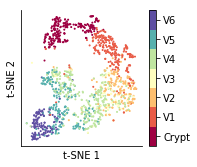

In [30]:
from intestine_info import load_enterocyte_meta_data
from plot_utils import plot_multi_scatter_discrete
cell_df = load_enterocyte_meta_data()
proj = cell_df[["tSNE_coordinate_1", "tSNE_coordinate_2"]]